In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import sklearn
from sklearn.metrics import cohen_kappa_score,accuracy_score

import time
from tqdm import tqdm_notebook

import os


In [2]:
train_folder="D:\Jupyter Files\Traffic Sign Recognition\GTSRB_Final_Training_Images\GTSRB\Final_Training\Images"
val_folder = 'D:/Jupyter Files/Traffic Sign Recognition/GTSRB_Final_Training_Images/GTSRB\Final_Training' + '/val_images'
if not os.path.isdir(val_folder):
    print(val_folder + ' not found, making a validation set')
    os.mkdir(val_folder)
    for dirs in os.listdir(train_folder):
        print(dirs)
        if dirs.startswith('000'):
            os.mkdir(val_folder + '/' + dirs)
            for f in os.listdir(train_folder + '/' + dirs):
                if f.startswith('00000') or f.startswith('00001') or f.startswith('00002'):
                    # move file to validation folder
                    os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)

In [3]:
print(len(os.listdir(train_folder)))

43


In [25]:
nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        x = self.maxpool4(x)        
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x,dim=1)

In [29]:
batch_size =50                                                                                                                                                                                     
epochs = 10                                                                                                                                                                                                                                                                                                                                                                               
seed = 1                                                                                                                                                                                           
log_interval=180   
nclasses = 43
data = "D:/Jupyter Files/Traffic Sign Recognition/GTSRB_Final_Training_Images/GTSRB"                                                                                                                                                                                                                                                                                                                                                                                          
torch.manual_seed(1)                                                                                                                                                                               
lr =0.007                                                                                                                                                                                          
momentum = 0.9                                                                                                                                                                                     
decay = 0.9                                                                                                                                                                                        
step = 1000                                                                                                                                                                                        
l2_norm = 0.00001  
cuda = True

In [6]:
# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 48 x 48 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms = transforms.Compose([
#     transforms.ToPILImage(mode='RGB'),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/Final_Training/Images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)


val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/Final_Training/val_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Net()
if cuda: 
    model.to(device)

cuda:0


In [7]:
print(torch.__version__) 

1.10.0+cu113


In [8]:
import torch

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system?True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:GeForce RTX 3050 Ti Laptop GPU


In [9]:
 torch.__version__

'1.10.0+cu113'

In [10]:
torch.cuda.get_arch_list()

['sm_37',
 'sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'compute_37']

In [11]:
print(torch.version.cuda)

11.3


In [23]:
def validation():
    model.eval().to(device)
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        data =data.to(device)
        target =target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss

def train(epoch , train_loader):
    model.train().to(device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target).cuda()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data))

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr , momentum=momentum, weight_decay=l2_norm, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)

In [15]:
torch.cuda.is_available()

True

In [21]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [30]:
for epoch in range(1, epochs):
    train(epoch, train_loader)
    val = validation()
    if epoch % step :
        scheduler.step()

C:\Users\Heril\AppData\Local\Temp/ipykernel_22392/969698797.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/35339 (0%)]	Loss: 1.543495
Train Epoch: 1 [9000/35339 (25%)]	Loss: 1.645278
Train Epoch: 1 [18000/35339 (51%)]	Loss: 1.774875
Train Epoch: 1 [27000/35339 (76%)]	Loss: 1.777056


C:\Users\Heril\AppData\Local\Temp/ipykernel_22392/3649215005.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Validation set: Average loss: 0.3988, Accuracy: 3618/3870 (93.488%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 1.234313
Train Epoch: 2 [9000/35339 (25%)]	Loss: 1.537463
Train Epoch: 2 [18000/35339 (51%)]	Loss: 1.385032
Train Epoch: 2 [27000/35339 (76%)]	Loss: 2.046384

Validation set: Average loss: 0.2937, Accuracy: 3687/3870 (95.271%)

Train Epoch: 3 [0/35339 (0%)]	Loss: 1.825904
Train Epoch: 3 [9000/35339 (25%)]	Loss: 1.782866
Train Epoch: 3 [18000/35339 (51%)]	Loss: 1.756194
Train Epoch: 3 [27000/35339 (76%)]	Loss: 1.916050

Validation set: Average loss: 0.2802, Accuracy: 3707/3870 (95.788%)

Train Epoch: 4 [0/35339 (0%)]	Loss: 1.625724
Train Epoch: 4 [9000/35339 (25%)]	Loss: 1.454638
Train Epoch: 4 [18000/35339 (51%)]	Loss: 1.436962
Train Epoch: 4 [27000/35339 (76%)]	Loss: 1.683388

Validation set: Average loss: 0.2824, Accuracy: 3723/3870 (96.202%)

Train Epoch: 5 [0/35339 (0%)]	Loss: 1.507162
Train Epoch: 5 [9000/35339 (25%)]	Loss: 1.396106
Train Epoch: 5 [18000/35339 (51%)]	Loss: 1.4

In [31]:
model_file = 'model_' + str(epoch) + '.pth'
torch.save(model.state_dict(), model_file)

In [33]:
test_csv=pd.read_csv('D:/Jupyter Files/Traffic Sign Recognition/GTSRB_Final_Test_GT/GT-final_test.csv',sep=';')
test_csv = test_csv[['Filename','ClassId']]
test_csv.head()

,Filename,ClassId
0,00000.ppm,16
1,00001.ppm,1
2,00002.ppm,38
3,00003.ppm,33
4,00004.ppm,11


In [35]:
class CreateTestDataset(Dataset):
    # the init method or the constructor method 
    def __init__(self,df_data,data_dir='../input/',transform=None):
        
        # the super() method dynamically represents the base class and super().__init__() calls the init method of base class 
        super().__init__()
        self.df=df_data.values
        self.data_dir=data_dir
        self.transform=transform
        
    # gives the length when len(instance) is called
    def __len__(self):
        return len(self.df)
    
    # getitem is used for extracting the instances attributes; generally used with lists , tuples
    def __getitem__(self,index):
        img_name,label=self.df[index]
        img_path=os.path.join(self.data_dir,img_name)
#         print(self.data_dir)
#         print(img_path)
        image=Image.open(img_path)
        
        if self.transform is not None:
            image=self.transform(image)
            
        return image,label

In [36]:
test_path="D:/Jupyter Files/Traffic Sign Recognition/GTSRB_Final_Test_Images/GTSRB\Final_Test/Images"
test_dataset=CreateTestDataset(df_data=test_csv,data_dir=test_path,transform=data_transforms)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1 , Predicted: 1


C:\Users\Heril\AppData\Local\Temp/ipykernel_22392/969698797.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


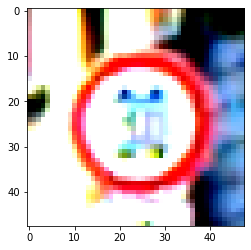

In [38]:
img,label= test_dataset[100]
plt.imshow(img.permute(1,2,0))
print('Label:',label, ', Predicted:', predict_image(img, model))

In [39]:
def get_labels_preds(dataset):
    sum=0
    labels=[]
    preds=[]
    for i in range(len(dataset)):
        img,label=dataset[i]
        x_test=predict_image(img,model)
        labels.append(label)
        preds.append(x_test)
    return labels,preds

In [40]:
from sklearn import metrics
y_test,y_pred=get_labels_preds(test_dataset)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('MCC:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred))

C:\Users\Heril\AppData\Local\Temp/ipykernel_22392/969698797.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy: 0.9792
Precision: 0.9795
Recall: 0.9792
F1 Score: 0.9789
Cohen Kappa Score: 0.9784
MCC: 0.9784
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.99      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       0.99      0.95      0.97       450
           4       1.00      0.99      0.99       660
           5       0.92      0.99      0.95       630
           6       1.00      0.87      0.93       150
           7       0.98      0.99      0.98       450
           8       0.97      1.00      0.99       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.99      0.99      0.99       420
          12       0.97      1.00      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
    